In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

from src.get_data import collect_data_from_matches

from src.model_building import build_graph_from_frame, TemporalRunnerDataset, TemporalRunnerGNN, train_model, collate_fn, predict_optimal_run

from src.visualization_tools import plot_soccer_pitch
from src.visualization_tools import animate_run
from src.visualization_tools import plot_spatial_graph
from src.visualization_tools import plot_optimal_run

# Load Data

In [3]:
matches = [1886347]
possessions, run_features, tracking_data, player_to_team, merged = collect_data_from_matches(matches)


100%|██████████| 1/1 [00:38<00:00, 38.42s/it]


In [2]:
match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [3]:
merged.event_subtype.unique()

array(['pulling_wide', 'coming_short', 'behind', nan, 'support',
       'overlap', 'cross_receiver', 'dropping_off',
       'run_ahead_of_the_ball', 'pulling_half_space', 'underlap'],
      dtype=object)

In [4]:
run_types_to_predict = ['cross_receiver','behind',"run_ahead_of_the_ball","overlap","underlap","support"]
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]
run_type_vocab = {rt: i for i, rt in enumerate(sorted(run_types_to_predict))}

In [5]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [25]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])
    
    if frame_end - frame_start <= 10:
        return False

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = frame_start-10
    
    if lower_frame < tracking["frame_id"].min():
        return False
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

In [26]:
runs_to_predict

,possession_index,match_id,period_possession,phases_indexes_possession,frame_start_possession,frame_end_possession,team_id_possession,phase_types,possession_lead_to_shot,possession_lead_to_goal,...,passing_option_score,predicted_passing_option,n_simultaneous_runs,passing_option_at_start,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,run_curve_ratio,id,phases_indexes_run
2,0,1886347,1,"{np.int64(0), np.int64(1)}",28,107,1805,"{'create', 'direct'}",False,False,...,0.7705,True,2.0,False,2.0,4.0,2.0,0.007974,1_2,1.0
6,3,1886347,1,{np.int64(5)},301,351,4177,{'finish'},False,False,...,0.9433,True,2.0,True,0.0,6.0,6.0,0.028686,1_5,5.0
8,3,1886347,1,{np.int64(5)},301,351,4177,{'finish'},False,False,...,0.7773,True,0.0,True,4.0,5.0,1.0,0.014079,1_7,5.0
21,8,1886347,1,"{np.int64(13), np.int64(14), np.int64(15), np....",1091,1546,1805,"{'build_up', 'finish', 'create', 'chaotic'}",True,False,...,0.9504,True,0.0,True,10.0,10.0,0.0,0.030112,1_18,18.0
23,8,1886347,1,"{np.int64(13), np.int64(14), np.int64(15), np....",1091,1546,1805,"{'build_up', 'finish', 'create', 'chaotic'}",True,False,...,0.9296,True,1.0,False,1.0,3.0,2.0,0.008746,1_20,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,307,2017461,2,{np.int64(433)},69416,69508,4177,{'transition'},True,False,...,0.8647,True,0.0,True,1.0,1.0,0.0,0.006744,1_453,433.0
6152,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.7520,True,0.0,True,6.0,7.0,1.0,0.002256,1_454,435.0
6153,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.8043,True,0.0,True,5.0,5.0,0.0,0.010304,1_455,436.0
6154,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.9742,True,1.0,False,7.0,7.0,0.0,0.015923,1_456,436.0


<Axes: >

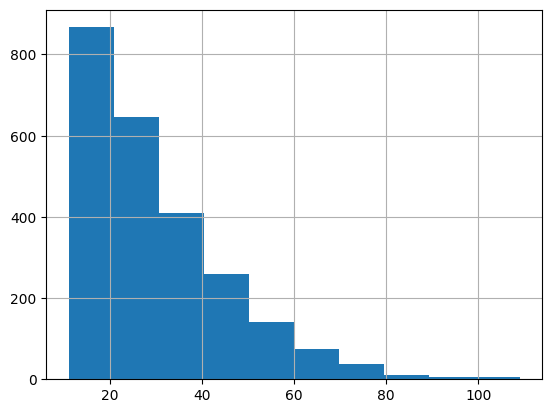

In [27]:
(runs_to_predict["frame_end_run"] - runs_to_predict["frame_start_run"]).hist()

# Build Graph

In [28]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23])

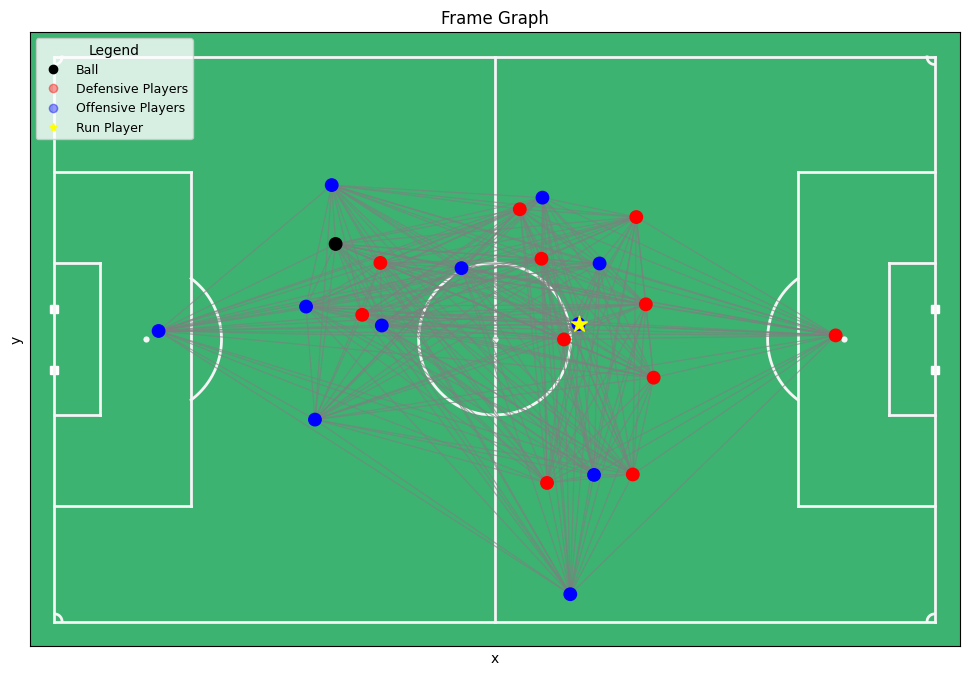

In [29]:
%matplotlib inline
plot_spatial_graph(graph)

In [30]:
run_type_vocab

{'behind': 0,
 'cross_receiver': 1,
 'overlap': 2,
 'run_ahead_of_the_ball': 3,
 'support': 4,
 'underlap': 5}

# Temporal Dataset class

In [31]:
class TemporalRunnerDataset(Dataset):
    def __init__(self, tracking_df, run_features, player_to_team):
        self.df = tracking_df
        self.run_features = run_features
        self.player_to_team = player_to_team

    def __len__(self):
        return len(self.run_features)

    def __getitem__(self, idx):
        run = self.run_features.iloc[idx]

        match_id = run["match_id"]
        run_id = run["event_id"]
        runner_id = run["player_id"]
        run_type = run["event_subtype"]
        run_type_id = run_type_vocab[run_type]

        frame_start = int(run["frame_start_run"])
        frame_end   = int(run["frame_end_run"])

        run_tracking = self.df[(match_id, run_id)]
        run_tracking = run_tracking.sort_values("frame_id")

        graphs = []
        runner_positions = []

        # --- anchor position ---
        start_row = run_tracking[
            (run_tracking["frame_id"] == frame_start) &
            (run_tracking["player"] == runner_id)
        ].iloc[0]

        x0, y0 = start_row["x"], start_row["y"]

        for t in range(frame_start - 10, frame_end + 1):
            frame_df = run_tracking[run_tracking["frame_id"] == t]

            g = build_graph_from_frame(
                frame_df=frame_df,
                runner_player_id=runner_id,
                player_to_team=self.player_to_team
            )
            graphs.append(g)

            runner_row = frame_df[frame_df["player"] == runner_id].iloc[0]
            runner_positions.append([
                runner_row["x"] - x0,
                runner_row["y"] - y0
            ])

        graphs_batch = Batch.from_data_list(graphs)

        target_path = torch.tensor(runner_positions, dtype=torch.float)  # [L,2]
        
        lead_to_shot_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_shot'].values
        if len(lead_to_shot_val) == 0:
            shot_label = torch.tensor(0.0) 
        else:
            shot_label = torch.tensor(float(lead_to_shot_val[0]))
        
        lead_to_goal_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_goal'].values
        if len(lead_to_goal_val) == 0:
            goal_label = torch.tensor(0.0) 
        else:
            goal_label = torch.tensor(float(lead_to_goal_val[0]))
        

        return graphs, target_path, shot_label, goal_label, run_type_id

def collate_fn(batch, max_len=110):
    graphs_list, targets_list, shot_labels_list, goal_labels_list, run_type_id_list = zip(*batch)

    batch_graphs = Batch.from_data_list([g for graphs in graphs_list for g in graphs])

    lengths = [len(target) for target in targets_list]

    padded_targets = torch.zeros(len(targets_list), max_len, 2)  # fixed max_len padding

    for i, target in enumerate(targets_list):
        length = min(len(target), max_len)
        padded_targets[i, :length] = target[:length]

    # Adjust lengths to max_len if longer sequences exist
    lengths = [min(l, max_len) for l in lengths]
    shot_labels = torch.tensor(shot_labels_list, dtype=torch.float)
    goal_labels = torch.tensor(goal_labels_list, dtype=torch.float)
    run_type_labels = torch.tensor(run_type_id_list, dtype=torch.long)


    return batch_graphs, padded_targets, lengths, shot_labels, goal_labels, run_type_labels

In [32]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
)
dataset

# Temporal GNN

In [33]:
from torch_geometric.nn import TransformerConv
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TemporalRunnerGNN_V4(nn.Module):
    def __init__(self, node_feat_dim, edge_dim, gnn_hidden_dim, K):
        super().__init__()

        self.gnn1 = TransformerConv(
            in_channels=node_feat_dim,
            out_channels=gnn_hidden_dim,
            heads=4,
            concat=False,
            edge_dim=edge_dim,
            dropout = .1
        )

        self.gnn2 = TransformerConv(
            in_channels=gnn_hidden_dim,
            out_channels=gnn_hidden_dim,
            heads=4,
            concat=False,
            edge_dim=edge_dim,
            dropout=.1
        )
        self.run_type_dim = 16

        self.temporal_proj = nn.Linear(
            gnn_hidden_dim + self.run_type_dim,
            gnn_hidden_dim
        )


        self.temporal_pe = nn.Parameter(
            torch.randn(1, 100, gnn_hidden_dim) * 0.01 
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=gnn_hidden_dim,
            nhead=4,
            dim_feedforward=4 * gnn_hidden_dim,
            dropout=0.1,
            batch_first=True
        )

        self.temporal_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2
        )
        num_run_types = K
        run_type_dim = 16

        self.run_type_head = nn.Linear(gnn_hidden_dim, num_run_types)
        self.run_type_emb = nn.Embedding(num_run_types, run_type_dim)
        
        self.pos_head = nn.Linear(gnn_hidden_dim, 2)
        self.shot_head = nn.Linear(gnn_hidden_dim, num_run_types) 
        
    def forward(self, graphs_batch, lengths):
        device = next(self.parameters()).device
        graphs_batch = graphs_batch.to(device)

        x, edge_index, edge_attr = graphs_batch.x, graphs_batch.edge_index,graphs_batch.edge_attr
        edge_attr = edge_attr / edge_attr.std(dim=0, keepdim=True).clamp(min=1e-6)

        x = F.relu(self.gnn1(x, edge_index, edge_attr))
        x = F.relu(self.gnn2(x, edge_index, edge_attr))

        batch_vec = graphs_batch.batch 
        runner_idx = graphs_batch.runner_idx  

        total_graphs = runner_idx.size(0)   

        B = len(lengths)
        max_len = max(lengths)

        runner_embeds_per_graph = []

        for t in range(total_graphs):
            node_mask = (batch_vec == t)
            node_indices = node_mask.nonzero(as_tuple=False).view(-1)
            global_runner_idx = node_indices[runner_idx[t]]
            runner_embeds_per_graph.append(x[global_runner_idx])

        runner_embeds_per_run = []
        start = 0
        for length in lengths:
            run_embeds = runner_embeds_per_graph[start:start+length]
            start += length

            if length < max_len:
                padding = [torch.zeros_like(run_embeds[0])]*(max_len - length)
                run_embeds.extend(padding)

            run_embeds = torch.stack(run_embeds)
            runner_embeds_per_run.append(run_embeds)

        runner_embeds_batch = torch.stack(runner_embeds_per_run)
        
        T_intent = 10
        T = runner_embeds_batch.size(1)
        x_intent = runner_embeds_batch[:, :T_intent]
        x_intent = x_intent + self.temporal_pe[:, :T_intent]

        intent_mask = torch.triu(
            torch.ones(T_intent, T_intent, device=x_intent.device),
            diagonal=1
        ).bool()

        intent_out = self.temporal_encoder(
            x_intent,
            mask=intent_mask
        )

        # summarize intent
        intent_state = intent_out[:, -1]  # (B, H)

        run_type_logits = self.run_type_head(intent_state)
        run_type_probs = F.softmax(run_type_logits, dim=-1)
        
        shot_logits_per_type = self.shot_head(intent_state)  # (B, K)
        shot_probs_per_type = F.softmax(shot_logits_per_type, dim=-1)  # (B, K)
        
        B, T = runner_embeds_batch.size(0), runner_embeds_batch.size(1)
        T_future = T - T_intent
        run_paths = []
        
        
        # For each run type, predict the future path conditioned on run type embedding
        for k in range(self.run_type_emb.num_embeddings):
            run_type_embed = self.run_type_emb.weight[k]  # (run_type_dim)
            run_type_embed = run_type_embed.unsqueeze(0).unsqueeze(0).expand(B, T_future, -1)  # (B, T_future, run_type_dim)

            x_future = runner_embeds_batch[:, T_intent:]
            x_future = torch.cat([x_future, run_type_embed], dim=-1)
            x_future = self.temporal_proj(x_future)
            x_future = x_future + self.temporal_pe[:, :T_future]
            
            future_mask = torch.triu(
                torch.ones(T_future, T_future, device=x_future.device),
                diagonal=1
            ).bool()

            future_padding_mask = (
                torch.arange(T_future, device=x_future.device)[None, :]
                >= (torch.tensor(lengths, device=x_future.device) - T_intent)[:, None]
            )

            # Use causal mask and padding mask for future frames as before
            future_out = self.temporal_encoder(
                x_future,
                mask=future_mask,
                src_key_padding_mask=future_padding_mask
            )

            pred_path = self.pos_head(future_out)  # (B, T_future, 2)
            run_paths.append(pred_path)

        run_paths = torch.stack(run_paths, dim=1)  # (B, K, T_future, 2)

        return {
            "run_type_logits": run_type_logits,
            "run_type_probs": run_type_probs,
            "shot_logits_per_type": shot_logits_per_type,  # (B, K)
            "shot_probs_per_type": shot_probs_per_type,    # (B, K)
            "run_paths_per_type": run_paths                 # (B, K, T_future, 2)
        }
        
        # run_type_embed = torch.matmul(
        #     run_type_probs,
        #     self.run_type_emb.weight
        # )  # (B, run_type_dim)
        
        # T_future = T - T_intent
        # run_type_embed = run_type_embed.unsqueeze(1).expand(
        #     -1, T_future, -1
        # )
        
        # x_future = runner_embeds_batch[:, T_intent:]
        # x_future = torch.cat([x_future, run_type_embed], dim=-1)
        # x_future = x_future * shot_prob[:, None, None]
        # x_future = self.temporal_proj(x_future)
        # x_future = x_future + self.temporal_pe[:, :T_future]
        
        # future_mask = torch.triu(
        #     torch.ones(T_future, T_future, device=x_future.device),
        #     diagonal=1
        # ).bool()

        # future_padding_mask = (
        #     torch.arange(T_future, device=x_future.device)[None, :]
        #     >= (torch.tensor(lengths, device=x_future.device) - T_intent)[:, None]
        # )
        
        # future_out = self.temporal_encoder(
        #     x_future,
        #     mask=future_mask,
        #     src_key_padding_mask=future_padding_mask
        # )

        # pred_future = self.pos_head(future_out)
        
        # return {
        #     "pred_path": pred_future,
        #     "run_type_logits": run_type_logits,
        #     "run_type_probs": run_type_probs,
        #     "shot_logits": shot_logits,
        #     "shot_prob":shot_prob
        # }
        
        
        
        # T = runner_embeds_batch.size(1)

        # # add positional encoding
        # x = runner_embeds_batch + self.temporal_pe[:, :T]

        # # causal mask (no peeking into future)
        # causal_mask = torch.triu(
        #     torch.ones(T, T, device=x.device),
        #     diagonal=1
        # ).bool()

        # # padding mask
        # padding_mask = torch.arange(T, device=x.device)[None, :] >= torch.tensor(lengths, device=x.device)[:, None]

        # out = self.temporal_encoder(
        #     x,
        #     mask=causal_mask,
        #     src_key_padding_mask=padding_mask
        # )

        # pred_path = self.pos_head(out)
        # return pred_path

In [34]:
node_feat_dim = 10
edge_dim = 4
gnn_hidden_dim = 64   
K = len(run_type_vocab)
model = TemporalRunnerGNN_V4(node_feat_dim,edge_dim,gnn_hidden_dim,K)
#model = TemporalRunnerGNN(node_feat_dim, gnn_hidden_dim, rnn_hidden_dim)

# Training Loop

In [35]:
def train_model_v4(
    model,
    device,
    dataloader,
    num_epochs=10,
    output_file="temporal_runner_gnn_v4.pth"
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    lambda_vel = 1.0
    lambda_acc = 0.1
    lambda_speed = 0.5
    lambda_type = 0.5
    lambda_shot = 0.5

    v_max = 9.5
    dt = 0.1
    T_intent = 10

    shot_weight = 2.0
    goal_weight = 3.0
    base_weight = 1.0

    ce_loss = nn.CrossEntropyLoss()

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for (
            batch_graphs,
            padded_targets,
            lengths,
            shot_labels,
            goal_labels,
            run_type_labels
        ) in tqdm(dataloader):

            batch_graphs = batch_graphs.to(device)
            padded_targets = padded_targets.to(device)
            shot_labels = shot_labels.to(device)
            goal_labels = goal_labels.to(device)
            run_type_labels = run_type_labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_graphs, lengths)

            run_type_logits = outputs["run_type_logits"]           # (B, K)
            shot_logits_per_type = outputs["shot_logits_per_type"] # (B, K)
            run_paths_per_type = outputs["run_paths_per_type"]     # (B, K, T_future, 2)

            # ---------------------------
            # Run-type classification loss
            # ---------------------------
            loss_type = ce_loss(run_type_logits, run_type_labels)

            # ---------------------------
            # Shot probability loss (only for true run type)
            # ---------------------------
            batch_size = run_type_labels.size(0)
            batch_indices = torch.arange(batch_size, device=device)

            shot_logits_true_type = shot_logits_per_type[batch_indices, run_type_labels]  # (B,)
            shot_loss = F.binary_cross_entropy_with_logits(shot_logits_true_type, shot_labels)

            # ---------------------------
            # Trajectory loss on predicted path for true run type
            # ---------------------------
            loss = 0.0

            for i, length in enumerate(lengths):
                if length <= T_intent + 1:
                    continue

                T_future = length - T_intent

                # Select predicted path for true run type i
                pred_seq = run_paths_per_type[i, run_type_labels[i], :T_future]  # (T_future, 2)
                target_seq = padded_targets[i, T_intent:length]                  # (T_future, 2)

                # Position loss
                loss_pos = F.mse_loss(pred_seq, target_seq)

                # Velocity loss
                pred_vel = (pred_seq[1:] - pred_seq[:-1]) / dt
                target_vel = (target_seq[1:] - target_seq[:-1]) / dt
                loss_vel = F.mse_loss(pred_vel, target_vel)

                # Speed penalty
                speed = torch.norm(pred_vel, dim=-1)
                excess_speed = torch.relu(speed - v_max)
                loss_speed = torch.mean(excess_speed ** 2)

                # Acceleration loss
                if pred_vel.size(0) > 1:
                    pred_acc = (pred_vel[1:] - pred_vel[:-1]) / dt
                    target_acc = (target_vel[1:] - target_vel[:-1]) / dt
                    loss_acc = F.mse_loss(pred_acc, target_acc)
                else:
                    loss_acc = 0.0

                sample_loss = (
                    loss_pos
                    + lambda_vel * loss_vel
                    + lambda_acc * loss_acc
                    + lambda_speed * loss_speed
                )

                sample_weight = (
                    base_weight
                    + shot_weight * shot_labels[i]
                    + goal_weight * goal_labels[i]
                )

                loss += sample_loss * sample_weight

            loss = loss / len(lengths)

            total_loss_val = loss + lambda_type * loss_type + lambda_shot * shot_loss

            total_loss_val.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += total_loss_val.item()

        print(f"Epoch {epoch+1}: loss = {total_loss / len(dataloader):.4f}")

    torch.save(model.state_dict(), output_file)

In [37]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = train_model_v4(model,device = device, dataloader=dataloader,num_epochs=1,output_file="models/temporal_runner_counter_factual.pth")


100%|██████████| 615/615 [12:06<00:00,  1.18s/it]

Epoch 1: loss = 88.5338


# Load Model From Saved State

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalRunnerGNN_V4(node_feat_dim,edge_dim,gnn_hidden_dim,K)
model.load_state_dict(torch.load("models/temporal_runner_counter_factual.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN_V4(
  (gnn1): TransformerConv(10, 64, heads=4)
  (gnn2): TransformerConv(64, 64, heads=4)
  (temporal_proj): Linear(in_features=80, out_features=64, bias=True)
  (temporal_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (run_type_head): Linear(in_features=64, out_features=6, bias=True)
  (run_type_emb): Embedding(6, 16)
  (pos_hea

# Given tracking data and runner id predict optimal run path

In [40]:
def predict_optimal_run_2(run,model,tracking_frame_groups,device,player_to_team):
    match_id = run['match_id']
    run_id = run['event_id']
    runner_id = run['player_id']
    team_id = run["team_id"]
    frame_start = int(run['frame_start_run'])
    frame_end = int(run['frame_end_run'])

    run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')

    graphs = []
    for t in range(frame_start, frame_end + 1):
        frame_df = run_tracking[run_tracking['frame_id'] == t]
        g = build_graph_from_frame(
            frame_df=frame_df,
            runner_player_id=runner_id,
            player_to_team=player_to_team
        )
        graphs.append(g)
        
    graphs_batch = Batch.from_data_list(graphs)
    length = len(graphs)
        
    lengths = [length]
    graphs_batch = graphs_batch.to(device)

    with torch.no_grad():
        output = model(graphs_batch, lengths)  
    run_type_probs = output["run_type_probs"].squeeze(0)
    shot_probs_per_type = output["shot_probs_per_type"].squeeze(0)
    run_paths_per_type = output["run_paths_per_type"].squeeze(0)
    # pred_path = pred_path.squeeze(0)  
    # run_length = lengths[0]
    # pred_path = pred_path[:run_length]

    # x0, y0 = run[["x_start","y_start"]] 
    # absolute_path = pred_path + torch.tensor([x0, y0], device=pred_path.device)
    return run_paths_per_type, run_type_probs, shot_probs_per_type

In [42]:
model.eval()
T = 10
RUN_NUM = 9
run = runs_to_predict.iloc[RUN_NUM]
match_id = run['match_id']
run_id = run['event_id']
runner_id = run['player_id']
team_id = run["team_id"]

run_paths_per_type, run_type_probs, shot_probs_per_type = predict_optimal_run_2(run,model,tracking_frame_groups=tracking_frame_groups,device = device,player_to_team = player_to_team)

In [58]:
shot_probs_per_type = shot_probs_per_type.numpy().tolist()
run_type_probs = run_type_probs.numpy().tolist()
run_paths_per_type = run_paths_per_type.numpy().tolist()
run_type_dict = {
    run_type: {
        "run_type_prob": run_type_probs[idx],
        "shot_prob": shot_probs_per_type[idx],
        "run_path": run_paths_per_type[idx],
    }
    for run_type, idx in run_type_vocab.items()
}
run_type_dict

{'behind': {'run_type_prob': 0.17177334427833557,
  'shot_prob': 0.13027392327785492,
  'run_path': [[6.639019966125488, 0.14325198531150818],
   [6.742175102233887, 0.14283840358257294],
   [6.850376129150391, 0.14112412929534912],
   [6.943596839904785, 0.13929927349090576],
   [7.00184440612793, 0.13817334175109863],
   [7.053952693939209, 0.13403552770614624],
   [7.082862854003906, 0.1353706568479538],
   [7.114672660827637, 0.1323053240776062],
   [7.122954845428467, 0.13444040715694427]]},
 'cross_receiver': {'run_type_prob': 0.07409512251615524,
  'shot_prob': 0.2444259077310562,
  'run_path': [[6.754568099975586, 0.14169180393218994],
   [6.85972785949707, 0.1411958932876587],
   [6.964622974395752, 0.13918143510818481],
   [7.05854606628418, 0.13716936111450195],
   [7.115087985992432, 0.13590210676193237],
   [7.165717124938965, 0.13143138587474823],
   [7.194879531860352, 0.13280080258846283],
   [7.224335670471191, 0.12954846024513245],
   [7.234005451202393, 0.13178764283

# Plot Optimal Run Path

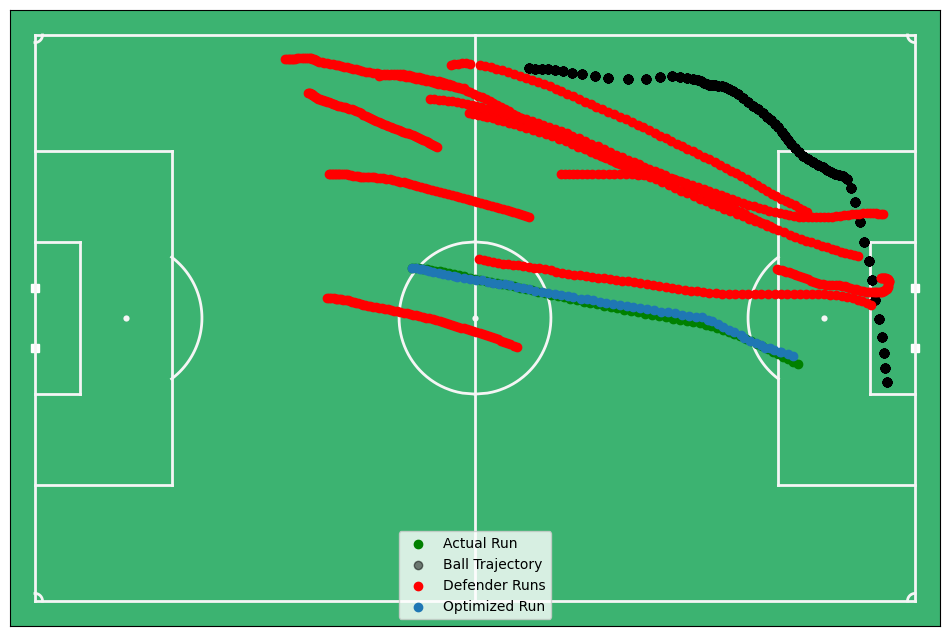

In [265]:
%matplotlib inline
plot_optimal_run(run,tracking_frame_groups=tracking_frame_groups,player_to_team=player_to_team,absolute_path=absolute_path)

# Animate Optimal Run

In [266]:
# Transform for animation
run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
pred_x = pd.Series(absolute_path[:,0])
pred_y = pd.Series(absolute_path[:,1])
dx = pred_x - pred_x.shift(1)
dy = pred_y - pred_y.shift(1)
s = np.sqrt(dx**2 + dy**2) * 10
d = np.arctan2(dy,dx)
pred_vals = pd.concat([pred_x,pred_y,dx,dy,s,d],axis=1)
pred_vals.columns = ["x","y","dx","dy","s","d"]
pred_vals["player"] = -1
pred_run = run_tracking[(run_tracking.run_active) & (run_tracking.player==runner_id)].copy()
pred_run.loc[:,["x","y","dx","dy","s","d","player"]] = pred_vals.fillna(0).values

In [267]:
%matplotlib tk

run_tracking_with_pred = pd.concat([run_tracking,pred_run])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)

# View run examples
run #26 for positioning between players

<Axes: xlabel='xthreat', ylabel='xpass_completion'>

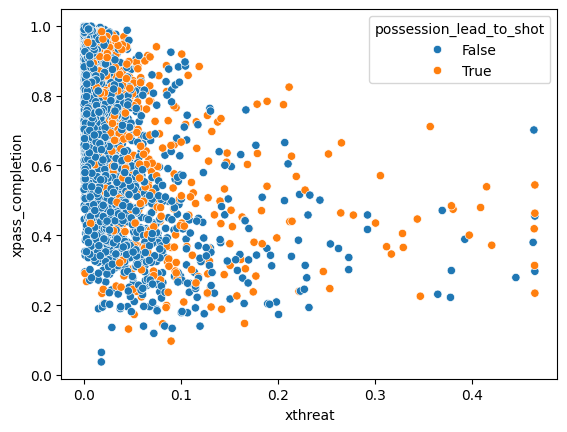

In [80]:
sns.scatterplot(data=merged.dropna(),x="xthreat",y="xpass_completion",hue = "possession_lead_to_shot")

In [56]:
xt, xpass,shot,goal = merged[["xthreat","xpass_completion","possession_lead_to_shot","possession_lead_to_goal"]].dropna().values.T

In [73]:
weights = 1 + xpass * (2* xt+shot*2+goal*3)

(array([3923.,   88.,  190.,  306.,   53.,    8.,   10.,   10.,   18.,
          17.]),
 array([1.        , 1.49685962, 1.99371923, 2.49057885, 2.98743846,
        3.48429808, 3.9811577 , 4.47801731, 4.97487693, 5.47173654,
        5.96859616]),
 <BarContainer object of 10 artists>)

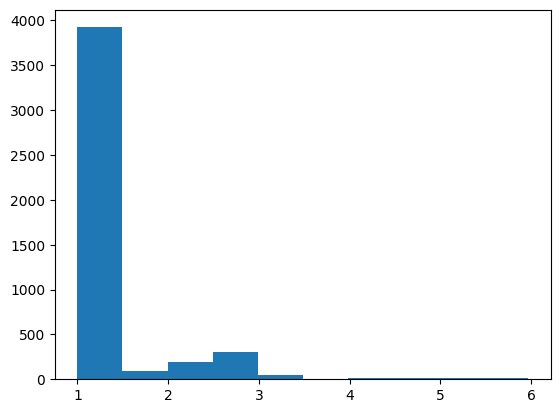

In [74]:
%matplotlib inline
plt.hist(weights)

In [71]:
weights2 =  1 + xt * xpass * (1+shot*2+goal*3)

(array([4.427e+03, 1.220e+02, 3.900e+01, 1.200e+01, 8.000e+00, 6.000e+00,
        5.000e+00, 0.000e+00, 3.000e+00, 1.000e+00]),
 array([1.        , 1.11025619, 1.22051238, 1.33076858, 1.44102477,
        1.55128096, 1.66153715, 1.77179334, 1.88204954, 1.99230573,
        2.10256192]),
 <BarContainer object of 10 artists>)

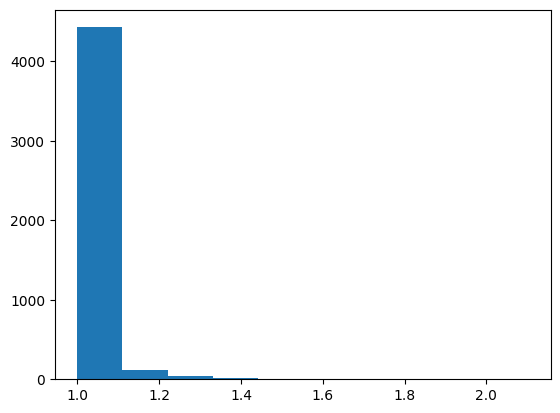

In [72]:
plt.hist(weights2)

<Axes: >

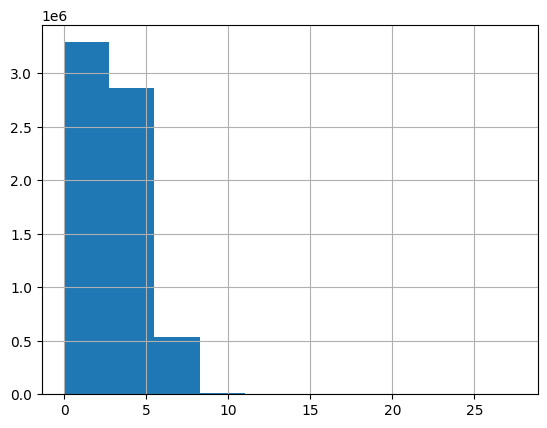

In [86]:
tracking_data["s"].hist()

In [144]:
test = run_tracking[run_tracking.player==runner_id]
acc = (test[["dx","dy"]] - test[["dx","dy"]].shift(1))[1:] / .1 ** 2
acc.apply(np.linalg.norm,axis=1).hist()

<Axes: >

,period_id,timestamp,frame_id,ball_x,ball_y,ball_speed,match_id,run_id,run_active,id,...,ball_dy,ball_dx_smooth,ball_dy_smooth,ball_ax,ball_ay,ball_ax_smooth,ball_ay_smooth,ball_speed_direction,ball_acceleration,ball_acc_direction
156713,1,0 days 00:29:24.800000,17658,14.41,13.53,433.132001,1886347,1_202,False,1_202,...,30.27,-6.070,5.866,-24.838,2.472400e+01,-1.1852,1.4980,2.367786,3504.420552,2.358495e+00
156714,1,0 days 00:29:24.900000,17659,14.68,14.03,5.682429,1886347,1_202,False,1_202,...,0.50,-6.008,6.178,6.340,-5.366000e+00,1.3028,-0.9452,1.075663,-170.912524,-7.023842e-01
156715,1,0 days 00:29:25,17660,14.98,14.56,6.090156,1886347,1_202,False,1_202,...,0.53,-5.954,6.470,6.308,-5.648000e+00,1.2864,-1.0108,1.055724,-180.789818,-7.302517e-01
156716,1,0 days 00:29:25.100000,17661,15.30,15.10,6.276942,1886347,1_202,False,1_202,...,0.54,0.302,0.510,6.274,-5.930000e+00,1.2656,-1.0836,1.035841,-190.302557,-7.572181e-01
156717,1,0 days 00:29:25.200000,17662,15.62,15.61,6.020797,1886347,1_202,False,1_202,...,0.51,0.290,0.492,0.018,-8.881784e-15,1.2460,-1.1572,1.010436,0.956682,-4.934325e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156774,1,0 days 00:29:30.900000,17719,45.47,-12.65,10.117806,1886347,1_202,False,1_202,...,-1.01,-0.034,-0.990,-0.038,-2.600000e-02,-0.0024,-0.0052,-1.630133,2.820767,-2.541542e+00
156775,1,0 days 00:29:31,17720,45.39,-13.70,10.530432,1886347,1_202,False,1_202,...,-1.05,-0.044,-1.014,-0.046,-6.000000e-02,-1.2376,1.2460,-1.646840,6.332118,-2.224879e+00
156776,1,0 days 00:29:31.100000,17721,45.33,-14.77,10.716809,1886347,1_202,False,1_202,...,-1.07,-0.028,-1.020,-0.016,-5.600000e-02,-1.2240,1.3060,-1.626812,5.680790,-1.849096e+00
156777,1,0 days 00:29:31.200000,17722,45.34,-15.79,10.200490,1886347,1_202,False,1_202,...,-1.02,-6.212,5.236,0.038,-3.108624e-15,-1.2072,1.3712,-1.560993,0.037253,-8.180591e-14
